<a href="https://colab.research.google.com/github/idocarmo/sentimento/blob/develop/notebooks/2.0-icc-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.4 MB/s eta 0:00:00


In [4]:
import re
import numpy as np
import string
from typing import List
from typing import Iterable

import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

## Loading Data

In [5]:
def load_data_splits():
    raw_train_dataset, test_dataset = load_dataset('maritaca-ai/imdb_pt', split=['train', 'test'])
    raw_train_dataset = raw_train_dataset.train_test_split(0.2)

    return raw_train_dataset['train'], raw_train_dataset['test'], test_dataset

In [6]:
train_dataset, validation_dataset, test_dataset = load_data_splits()

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test_all split: 0 examples [00:00, ? examples/s]

Dataset imdb_pt downloaded and prepared to /root/.cache/huggingface/datasets/maritaca-ai___imdb_pt/plain_text/1.0.0/ffeeea85dfdf69a15638f37cdae931de451276b0fbc70c92f7cad159b96abb05. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Data Processing

In [23]:
VOCAB_SIZE = 10000
MAX_TOKENS = 256
BATCH_SIZE = 32

class DataPipeline:
    def __init__(self) -> None:
        self.vectorizer_layer = layers.TextVectorization(
            max_tokens=VOCAB_SIZE,
            standardize=self.standardize_text,
            output_mode='int',
            output_sequence_length=MAX_TOKENS,
            pad_to_max_tokens=True,
            encoding='utf-8',
        )

    def fit_transform(self, corpus: Iterable[str]):
        corpus_tensor = self.compose_corpus_tensor(corpus)
        self.vectorizer_layer.adapt(corpus_tensor, batch_size=BATCH_SIZE)
        return self.vectorizer_layer(corpus_tensor)

    def transform(self, corpus: Iterable[str]):
        corpus_tensor = self.compose_corpus_tensor(corpus)
        return self.vectorizer_layer(corpus_tensor)

    @staticmethod
    def standardize_text(input_data: Iterable[str]) -> tf.Tensor:
        lowercase = tf.strings.lower(input_data)
        standardized = tf.strings.regex_replace(
            lowercase, 
            '[%s]' % re.escape(string.punctuation),
            ''
        )
        return standardized

    @staticmethod
    def compose_corpus_tensor(corpus: Iterable[str]) -> tf.Tensor:
        corpus_tensor = tf.expand_dims(corpus, -1)
        return corpus_tensor

    @staticmethod
    def split_data_target(dataset: datasets.arrow_dataset.Dataset):
        return np.array(dataset['text']), np.array(dataset['label'])

In [24]:
data_pipeline = DataPipeline()

In [25]:
train_data, train_labels = data_pipeline.split_data_target(train_dataset)
validation_data, validation_labels = data_pipeline.split_data_target(validation_dataset)
test_data, test_labels = data_pipeline.split_data_target(test_dataset)

In [26]:
X_train = data_pipeline.fit_transform(train_data)

X_val = data_pipeline.transform(validation_data)
X_test = data_pipeline.transform(test_data)

## Model

In [27]:
EMBEDDING_DIM = 2

model = keras.Sequential([
  layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM, input_length=256),
  layers.Flatten(),
  layers.Dropout(rate=0.5),
  layers.Dense(5),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 2)            20002     
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.Precision(), tf.metrics.Recall()])

In [29]:
EPOCHS = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1)

history = model.fit(X_train,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=100,
                    validation_data=(X_val, validation_labels),
                    callbacks=[callback],
                    verbose=1)

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6878 - binary_accuracy: 0.5444 - precision_1: 0.5407 - recall_1: 0.5918 - val_loss: 0.6630 - val_binary_accuracy: 0.6652 - val_precision_1: 0.6351 - val_recall_1: 0.7745
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5291 - binary_accuracy: 0.7574 - precision_1: 0.7545 - recall_1: 0.7634 - val_loss: 0.4142 - val_binary_accuracy: 0.8194 - val_precision_1: 0.7779 - val_recall_1: 0.8935
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3666 - binary_accuracy: 0.8424 - precision_1: 0.8348 - recall_1: 0.8538 - val_loss: 0.3353 - val_binary_accuracy: 0.8638 - val_precision_1: 0.8541 - val_recall_1: 0.8771
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3120 - binary_accuracy: 0.8689 - precision_1: 0.8624 - recall_1: 0.8779 - val_loss: 0.3159 - val_binary_accuracy: 0.8720 - val_precision_1: 0.8584 - val_recall_1: 0.8907
Epoch 5/10
200/

In [14]:
history_dict = history.history

def plot_metric(history_dict: dict, metric: str='binary_accuracy', title: str=''):
    ''' Plot the metrics results for Neural Network epochs

    Args:
        history_dict: dictionary with Neural Networks metric results
        metric: name of the metric to be ploted. Default: 'binary_accuracy'
        title: string with plot title
    '''
    train_result = history_dict[metric]
    validation_result = history_dict['val_' + metric]
    epochs = range(1, len(train_result) + 1)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(epochs, train_result, label='train')
    ax.plot(epochs, validation_result, label='validation')
    ax.set_title(title) 
    ax.set_xlabel('epoch')
    ax.set_xticks(epochs)
    plt.legend(loc='best')
    plt.show()

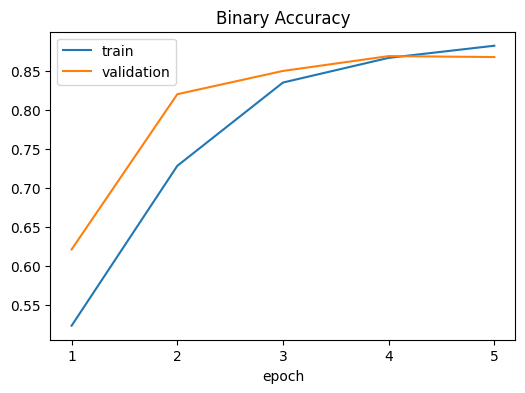

In [15]:
plot_metric(history_dict, metric='binary_accuracy', title='Binary Accuracy')

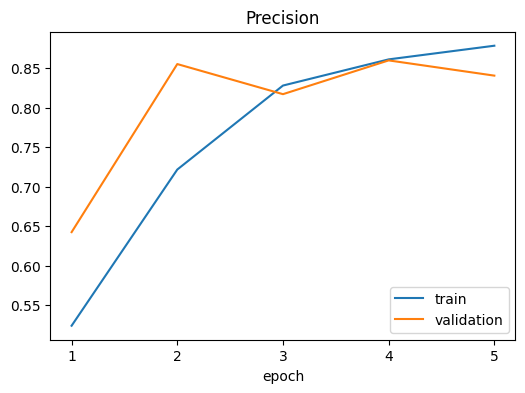

In [16]:
plot_metric(history_dict, metric='precision', title='Precision')

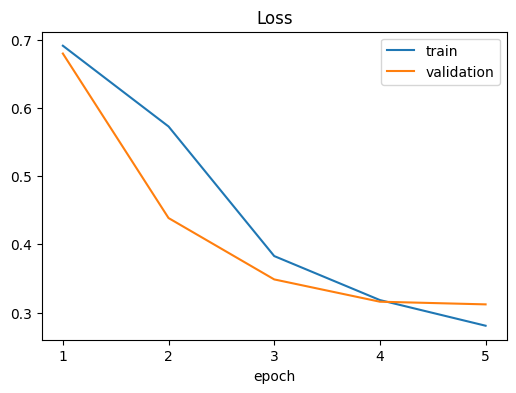

In [17]:
plot_metric(history_dict, metric='loss', title='Loss')

In [37]:
export_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    data_pipeline.vectorizer_layer,
    model,  
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [44]:
export_model.evaluate(*data_pipeline.split_data_target(test_dataset))

157/157 [==============================] - 2s 10ms/step - loss: 0.3218 - accuracy: 0.8640


[0.3218224346637726, 0.8640000224113464]

In [47]:
model.evaluate(X_train, train_labels)

625/625 [==============================] - 3s 4ms/step - loss: 0.2034 - binary_accuracy: 0.9294 - precision_1: 0.9257 - recall_1: 0.9339


[0.20335423946380615,
 0.9294499754905701,
 0.9256837368011475,
 0.9339198470115662]

In [48]:
model.evaluate(X_val, validation_labels)

157/157 [==============================] - 0s 2ms/step - loss: 0.3088 - binary_accuracy: 0.8700 - precision_1: 0.8609 - recall_1: 0.8823


[0.308795690536499, 0.8700000047683716, 0.8608831763267517, 0.8822587132453918]

In [49]:
model.evaluate(X_test, test_labels)

157/157 [==============================] - 1s 4ms/step - loss: 0.3218 - binary_accuracy: 0.8640 - precision_1: 0.8767 - recall_1: 0.8472


[0.3218224346637726, 0.8640000224113464, 0.876655638217926, 0.8471999764442444]

In [ ]:
import scikitplot as skplt
from sklearn import metrics

In [ ]:
metrics.confusion_matrix(*proba_pred)

In [ ]:
import scikitplot as skplt

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

#Normalized confusion matrix for the K-NN model

prediction_labels = knn_classifier.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, prediction_labels, normalize=True)
plt.show()

In [ ]:
def cm_plot(cm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')